In [1]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from keras.layers import Dense, Input
from keras.layers import Conv2D, Flatten, Lambda, LeakyReLU, BatchNormalization
from keras.layers import Reshape, Conv2DTranspose
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt
import argparse
import os
from PIL import Image
from platform import python_version

print(python_version())

Using TensorFlow backend.


3.5.0


In [2]:
# reparameterization trick
# instead of sampling from Q(z|X), sample eps = N(0,I)
# then z = z_mean + sqrt(var)*eps
def sampling(args):
    """Reparameterization trick by sampling fr an isotropic unit Gaussian.

    # Arguments
        args (tensor): mean and log of variance of Q(z|X)

    # Returns
        z (tensor): sampled latent vector
    """

    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(0.5 * z_log_var) * epsilon

In [9]:
## Data loading 

# trainData = "C:/Users/mostafaosama2/Desktop/autoenctrain/train"
trainData = "finalproject/Data/train"
# testData = "C:/Users/mostafaosama2/Desktop/autoenctrain/test"
testData = "finalproject/Data/test"

new_train = []
new_test = []

for filename in os.listdir(trainData):
    if filename.endswith('.tif'):
        image = Image.open(os.path.join(trainData, filename))
        new_train.append(np.asarray( image, dtype="uint8" ))

for filename in os.listdir(testData):
    if filename.endswith('.tif'):
        image = Image.open(os.path.join(testData, filename))
        new_test.append(np.asarray( image, dtype="uint8" ))

## Data preprocessing

x_train = np.asarray(new_train)
x_test = np.asarray(new_test)
x_train = x_train.astype('float32') / 255.
x_test = x_test.astype('float32') / 255.



In [21]:
image_size = x_train.shape[1]
# network parameters
input_shape = (image_size, image_size, 3)
batch_size = 64
kernel_size = 3
filters = 16
latent_dim = 4
epochs = 50
input_shape

(96, 96, 3)

In [22]:
# VAE model = encoder + decoder
# build encoder model
inputs = Input(shape=input_shape, name='encoder_input')
x = inputs
for i in range(2):
    filters *= 2
    x = Conv2D(filters=filters,
               kernel_size=kernel_size,
               strides=2,
               padding='same')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(16)(x)
x = LeakyReLU()(x)
x = BatchNormalization()(x)

z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var')(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')


In [23]:
# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(shape[1] * shape[2] * shape[3])(latent_inputs)
x = LeakyReLU()(x)
x = BatchNormalization()(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
    x = Conv2DTranspose(filters=filters,
                        kernel_size=kernel_size,
                        strides=2,
                        padding='same')(x)
    x = LeakyReLU()(x)
    x = BatchNormalization()(x)
    
    filters //= 2

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')


In [24]:
x_train.shape

(9999, 96, 96, 3)

In [25]:
x_test.shape

(1500, 96, 96, 3)

In [26]:
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 96, 96, 3)    0                                            
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 48, 48, 32)   896         encoder_input[0][0]              
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 24, 24, 64)   18496       conv2d_5[0][0]                   
__________________________________________________________________________________________________
flatten_3 (Flatten)             (None, 36864)        0           conv2d_6[0][0]                   
____________________________________________________________________________________________

In [27]:
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
z_sampling (InputLayer)      (None, 2)                 0         
_________________________________________________________________
dense_7 (Dense)              (None, 36864)             110592    
_________________________________________________________________
reshape_4 (Reshape)          (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_transpose_7 (Conv2DTr (None, 48, 48, 64)        36928     
_________________________________________________________________
conv2d_transpose_8 (Conv2DTr (None, 96, 96, 32)        18464     
_________________________________________________________________
decoder_output (Conv2DTransp (None, 96, 96, 3)         867       
Total params: 166,851
Trainable params: 166,851
Non-trainable params: 0
_____________________________________________________

In [28]:
models = (encoder, decoder)
reconstruction_loss = mse(K.flatten(inputs), K.flatten(outputs))

reconstruction_loss *= image_size * image_size
kl_loss = 1 + z_log_var - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

filepath = "VAEcheckpoint_epochs{}_batch{}_{}.h5".format(epochs,batch_size,latent_dim)
checkpoint = ModelCheckpoint(filepath, monitor='loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]

vae = vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_data=(x_test, None),
            callbacks=callbacks_list)



/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/keras/engine/training_utils.py:819: UserWarning: Output decoder missing from loss dictionary. We assume this was done on purpose. The fit and evaluate APIs will not be expecting any data to be passed to decoder.
  'be expecting any data to be passed to {0}.'.format(name))


Train on 9999 samples, validate on 1500 samples
Epoch 1/30
9999/9999 [==============================] - 99s 10ms/step - loss: 910.2587 - val_loss: 418.8766
Epoch 2/30
9999/9999 [==============================] - 100s 10ms/step - loss: 427.2891 - val_loss: 394.2790
Epoch 3/30
9999/9999 [==============================] - 104s 10ms/step - loss: 406.5772 - val_loss: 384.1337
Epoch 4/30
9999/9999 [==============================] - 104s 10ms/step - loss: 397.0790 - val_loss: 393.7328
Epoch 5/30
9999/9999 [==============================] - 101s 10ms/step - loss: 391.6193 - val_loss: 388.9833
Epoch 6/30
9999/9999 [==============================] - 93s 9ms/step - loss: 386.0070 - val_loss: 397.7505
Epoch 7/30
9999/9999 [==============================] - 92s 9ms/step - loss: 383.1757 - val_loss: 381.4211
Epoch 8/30
9999/9999 [==============================] - 90s 9ms/step - loss: 382.1943 - val_loss: 382.3080
Epoch 9/30
9999/9999 [==============================] - 94s 9ms/step - loss: 379.9918 -

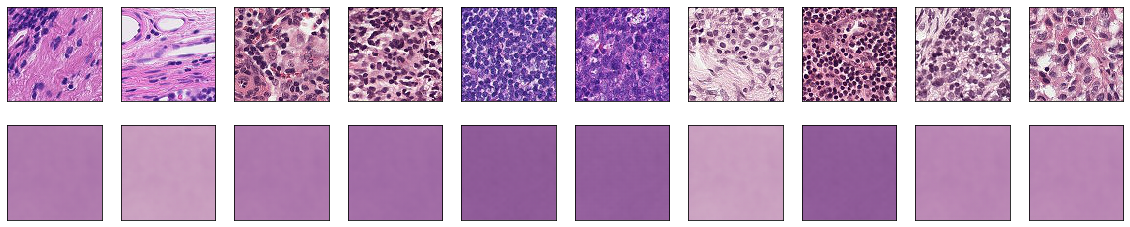

In [31]:
decoded_imgs = vae.predict(x_test)
n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(n):
    # display original
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_test[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

In [32]:
loss = autoencoder_train.history['loss']
val_loss = autoencoder_train.history['val_loss']
epochs = range(n_epochs)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

autoencoder.save('VAE_epochs{}_batch{}_{}_{}.h5'.format(n_epochs, batch_size, optimizer, loss[-1]))

NameError: name 'autoencoder_train' is not defined

In [33]:
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt 

layer_name = 'z_sampling'
intermediate_layer_model = Model(inputs=autoencoder.input,
                                 outputs=autoencoder.get_layer(layer_name).output)

encoded_imgs = intermediate_layer_model.predict(x_test)
print(encoded_imgs.shape)
# meanMatrix = meanMatrix.reshape((1500,-1))
pca = PCA(n_components=50)
pcatransformedData = pca.fit_transform(encoded_imgs)
print(pcatransformedData.shape)
plt.scatter(pcatransformedData[:, 0], pcatransformedData[:, 1])

NameError: name 'autoencoder' is not defined

In [ ]:
tsne = TSNE(n_components=2)
transformedData = tsne.fit_transform(pcatransformedData)

print(transformedData.shape)
plt.scatter(transformedData[:, 0], transformedData[:, 1])